Environment & dependencies

In [1]:
# 0.1 — Clone the official repo
!git clone https://github.com/mbzuai-nlp/SemEval-2026-Task13.git
!cd SemEval-2026-Task13

# 0.2 — Create & activate a virtual env
!python3 -m venv .venv
!source .venv/bin/activate   # on Windows PowerShell:  .\.venv\Scripts\Activate.ps1

# 0.3 — Minimal dependencies (CPU)
!python -m pip install --upgrade pip
!pip install pandas pyarrow scikit-learn scipy tqdm kaggle joblib


fatal: destination path 'SemEval-2026-Task13' already exists and is not an empty directory.
/bin/bash: line 1: python: command not found
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!mkdir -p ~/.kaggle
!cp /home/marwa/Downloads/assignment2/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat '/home/marwa/Downloads/assignment2/kaggle.json': No such file or directory


In [3]:
!kaggle competitions list --search sem-eval


ref                                                                  deadline             category   reward  teamCount  userHasEntered  
-------------------------------------------------------------------  -------------------  ---------  ------  ---------  --------------  
https://www.kaggle.com/competitions/sem-eval-2026-task-13-subtask-a  2026-01-24 20:00:00  Community   Kudos         15            True  
https://www.kaggle.com/competitions/sem-eval-2026-task-13-subtask-c  2026-01-24 20:00:00  Community   Kudos          2           False  
https://www.kaggle.com/competitions/sem-eval-2026-task-13-subtask-b  2026-01-24 20:00:00  Community   Kudos          0           False  


In [4]:
# 1) Create data dir
!mkdir -p /home/marwa/Downloads/assignment2/data
!cd /home/marwa/Downloads/assignment2

# 2) Inspect files for THIS competition (verifies rules accepted)
!kaggle competitions files -c sem-eval-2026-task-13-subtask-a

# 3) Download + unzip
!kaggle competitions download -c sem-eval-2026-task-13-subtask-a -p ./data
!unzip -o ./data/sem-eval-2026-task-13-subtask-a.zip -d ./data

# 4) Sanity check
!ls -lh ./data/Task_A

name                                size  creationDate                
----------------------------  ----------  --------------------------  
Task_A/sample_submission.csv        9987  2025-10-13 15:50:48.194000  
Task_A/test.parquet               594987  2025-10-13 15:50:48.194000  
Task_A/test_sample.parquet        593282  2025-10-13 15:50:48.194000  
Task_A/train.parquet           203162674  2025-10-13 15:50:48.194000  
Task_A/validation.parquet       40513121  2025-10-13 15:50:48.194000  
sem-eval-2026-task-13-subtask-a.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./data/sem-eval-2026-task-13-subtask-a.zip
  inflating: ./data/Task_A/sample_submission.csv  
  inflating: ./data/Task_A/test.parquet  
  inflating: ./data/Task_A/test_sample.parquet  
  inflating: ./data/Task_A/train.parquet  
  inflating: ./data/Task_A/validation.parquet  
total 234M
-rw-rw-r-- 1 marwa marwa 9.8K Oct 13 15:51 sample_submission.csv
-rw-rw-r-- 1 marwa mar

In [5]:
from pathlib import Path

PROJECT_DIR = Path("/home/marwa/Downloads/assignment2")
KAGGLE_JSON = PROJECT_DIR / "kaggle.json"

# Where we'll keep data + outputs
DATA_DIR = PROJECT_DIR / "data"
TASK_A_DIR = DATA_DIR / "Task_A"
ART_DIR = PROJECT_DIR / "artifacts"

# Fast dev subset (0 = use all training rows)
SUBSET_N = 0   # e.g., 100_000 for quick runs, 0 for full

DATA_DIR.mkdir(parents=True, exist_ok=True)
ART_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_DIR:", PROJECT_DIR)
print("KAGGLE_JSON exists:", KAGGLE_JSON.exists())
print("DATA_DIR:", DATA_DIR)
print("ART_DIR:", ART_DIR)


PROJECT_DIR: /home/marwa/Downloads/assignment2
KAGGLE_JSON exists: False
DATA_DIR: /home/marwa/Downloads/assignment2/data
ART_DIR: /home/marwa/Downloads/assignment2/artifacts


In [6]:
# If your venv is fresh, run once.
# Re-run only if you see import errors later.
import sys
!{sys.executable} -m pip install -q --upgrade pandas pyarrow scikit-learn scipy tqdm kaggle joblib

In [7]:
# Cell 4 — Download & extract Task_A via Python Kaggle API (robust to return types)
from pathlib import Path
import zipfile, os
from kaggle import KaggleApi

COMP = "sem-eval-2026-task-13-subtask-a"

api = KaggleApi()
api.authenticate()  # uses ~/.kaggle/kaggle.json

# 1) List files (handles both list and response-object shapes)
resp = api.competition_list_files(COMP)
items = getattr(resp, "files", resp)  # some versions return obj with .files

print("Files in competition:")
try:
    for f in items:
        name = getattr(f, "name", str(f))
        size = getattr(f, "size", None)
        print(f" - {name}" + (f"\t({size} bytes)" if size is not None else ""))
except TypeError:
    # Fallback: just print the object and carry on
    print(" (could not iterate; raw response below)")
    print(resp)

# 2) Download all files into DATA_DIR
DATA_DIR.mkdir(parents=True, exist_ok=True)
print("\nDownloading to:", DATA_DIR)
api.competition_download_files(COMP, path=str(DATA_DIR), quiet=False, force=True)

# 3) Extract top-level zips in DATA_DIR
for z in DATA_DIR.glob("*.zip"):
    try:
        with zipfile.ZipFile(z, "r") as f:
            f.extractall(DATA_DIR)
        print("Extracted:", z.name)
    except zipfile.BadZipFile:
        print("Skipped bad zip:", z.name)

# 4) Extract any nested zips (if present)
for z in DATA_DIR.rglob("*.zip"):
    if z.parent == DATA_DIR:
        continue
    try:
        with zipfile.ZipFile(z, "r") as f:
            f.extractall(z.parent)
        print("Extracted nested:", z.relative_to(DATA_DIR))
    except zipfile.BadZipFile:
        pass

# 5) Show expectation paths
TASK_A_DIR = DATA_DIR / "Task_A"
print("\nExpect these to exist now:")
print(" -", TASK_A_DIR / "train.parquet")
print(" -", TASK_A_DIR / "test.parquet")


Files in competition:
 - Task_A/sample_submission.csv
 - Task_A/test.parquet
 - Task_A/test_sample.parquet
 - Task_A/train.parquet
 - Task_A/validation.parquet



100%|██████████| 203M/203M [00:00<00:00, 1.55GB/s]

Extracted: sem-eval-2026-task-13-subtask-a.zip

Expect these to exist now:
 - /home/marwa/Downloads/assignment2/data/Task_A/train.parquet
 - /home/marwa/Downloads/assignment2/data/Task_A/test.parquet


In [8]:
import pandas as pd
from pathlib import Path

TASK_A_DIR = Path("/home/marwa/Downloads/assignment2/data/Task_A")

train_path = TASK_A_DIR / "train.parquet"
test_path  = TASK_A_DIR / "test.parquet"
val_path   = TASK_A_DIR / "validation.parquet"

train_raw = pd.read_parquet(train_path)
test_raw  = pd.read_parquet(test_path)
val_raw   = pd.read_parquet(val_path) if val_path.exists() else None

# Normalize column names based on what you printed earlier
train = train_raw.rename(columns={"generator": "ID"})[["ID", "code", "label"]].copy()
test  = test_raw.rename(columns={"ID": "ID"})[["ID", "code"]].copy()

# Type consistency
train["ID"] = train["ID"].astype(str)
test["ID"]  = test["ID"].astype(str)
train["label"] = train["label"].astype(int)

print("TRAIN:", train.shape, "TEST:", test.shape)
print(train["label"].value_counts())


TRAIN: (500000, 3) TEST: (1000, 2)
label
1    261525
0    238475
Name: count, dtype: int64


In [9]:
import re

COMMENT_PATTERNS = [
    (r'//.*?$', re.MULTILINE),
    (r'/\*.*?\*/', re.DOTALL),
    (r'#.*?$', re.MULTILINE),
    (r'"""[\s\S]*?"""', 0),
    (r"'''[\s\S]*?'''", 0),
]

def strip_comments(code: str) -> str:
    s = str(code)
    for pat, flags in COMMENT_PATTERNS:
        s = re.sub(pat, " ", s, flags=flags)
    return s

train = train.copy()
test = test.copy()
train["code_nocom"] = train["code"].map(strip_comments)
test["code_nocom"]  = test["code"].map(strip_comments)

print(train[["code", "code_nocom"]].head(2))


                                                code  \
0  (a, b, c, d) = [int(x) for x in input().split(...   
1  valid version for the language; all others can...   

                                          code_nocom  
0  (a, b, c, d) = [int(x) for x in input().split(...  
1  valid version for the language; all others can...  


In [10]:
from sklearn.feature_extraction.text import HashingVectorizer
from scipy import sparse as sp
import numpy as np

# Character-level hashing 
N_CHAR = 2**18  # 262k features
CGRAMS = (3,5)

char_hash = HashingVectorizer(
    analyzer="char",
    ngram_range=CGRAMS,
    n_features=N_CHAR,
    alternate_sign=False,
    norm="l2",
    dtype=np.float32,
)

X_train = char_hash.transform(train["code_nocom"])
X_test  = char_hash.transform(test["code_nocom"])
y_train = train["label"].astype(int).values

print("Features ready:", X_train.shape, X_test.shape)


Features ready: (500000, 262144) (1000, 262144)


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(y_train))
test_logits = np.zeros(X_test.shape[0])

for tr, va in skf.split(X_train, y_train):
    clf = LogisticRegression(
        max_iter=400, solver="saga", n_jobs=-1,
        class_weight="balanced", C=2.0
    )
    clf.fit(X_train[tr], y_train[tr])
    oof[va] = clf.predict_proba(X_train[va])[:, 1]
    test_logits += clf.predict_proba(X_test)[:, 1] / skf.n_splits

def tune_thresh(y, s):
    best_t, best_f1 = 0.5, 0
    for t in np.linspace(0.2, 0.8, 121):
        f = f1_score(y, (s >= t).astype(int), average="macro")
        if f > best_f1:
            best_t, best_f1 = t, f
    return best_t, best_f1

t_opt, f1_cv = tune_thresh(y_train, oof)
print(f"CV macro-F1: {f1_cv:.4f} | Optimal threshold: {t_opt:.3f}")


CV macro-F1: 0.9555 | Optimal threshold: 0.455


In [24]:
import pandas as pd
from pathlib import Path

pred = (test_logits >= t_opt).astype(int)
sub = pd.DataFrame({"ID": test["ID"].astype(str), "label": pred})
sub.to_csv("/home/marwa/Desktop/Assignment2_NLP/artifacts/submission.csv", index=False)
print("Saved:", "/home/marwa/Desktop/Assignment2_NLP/artifacts/submission.csv")
sub.head()


Saved: /home/marwa/Desktop/Assignment2_NLP/artifacts/submission.csv


,ID,label
2005,2005,1
2384,2384,0
3526,3526,0
3926,3926,0
7222,7222,1


In [13]:
import pandas as pd

print("=== Sample rows from TRAIN ===")
display(train.head(10)[["ID", "label", "code"]])

=== Sample rows from TRAIN ===


,ID,label,code
0,human,0,"(a, b, c, d) = [int(x) for x in input().split(..."
1,Qwen/Qwen2.5-Coder-1.5B,1,valid version for the language; all others can...
2,Qwen/Qwen2.5-Coder-7B-Instruct,1,python\ndef min_cards_to_flip(s):\n vowels ...
3,human,0,T = int(input())\nfor t in range(T):\n\tcolor ...
4,human,0,for i in range(int(input())):\n\tinput()\n\ta ...
5,human,0,n = int(input())\na = [int(x) for x in input()...
6,microsoft/phi-2,1,l=[]\nfor i in range(int(input())):\n n = i...
7,microsoft/Phi-3-medium-4k-instruct,1,def is_wilson_prime(p):\n if not isinstance...
8,codellama/CodeLlama-70b-Instruct-hf,1,def can_divide_watermelon(w):\n # If the wa...
9,human,0,def math(s):\n\tif len(s) <= 100:\n\t\tfor i i...


/home/marwa/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


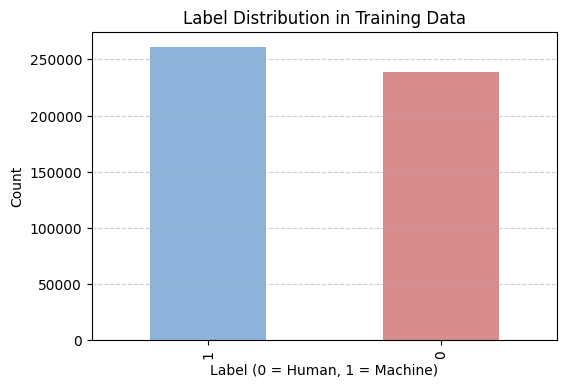

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
train["label"].value_counts().plot(kind="bar", color=["#8cb3d9", "#d98c8c"])
plt.title("Label Distribution in Training Data")
plt.xlabel("Label (0 = Human, 1 = Machine)")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

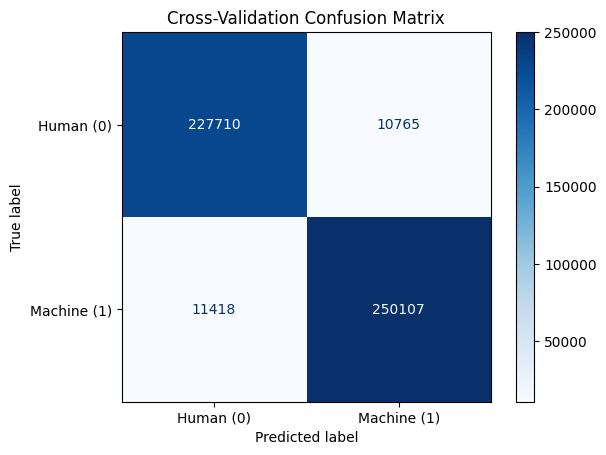

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# thresholded predictions from CV
y_pred_cv = (oof >= t_opt).astype(int)
cm = confusion_matrix(y_train, y_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human (0)", "Machine (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Cross-Validation Confusion Matrix")
plt.show()

In [16]:
from sklearn.metrics import classification_report

print("Classification report (CV predictions):")
print(classification_report(y_train, y_pred_cv, target_names=["Human", "Machine"], digits=4))

Classification report (CV predictions):
              precision    recall  f1-score   support

       Human     0.9523    0.9549    0.9536    238475
     Machine     0.9587    0.9563    0.9575    261525

    accuracy                         0.9556    500000
   macro avg     0.9555    0.9556    0.9555    500000
weighted avg     0.9556    0.9556    0.9556    500000



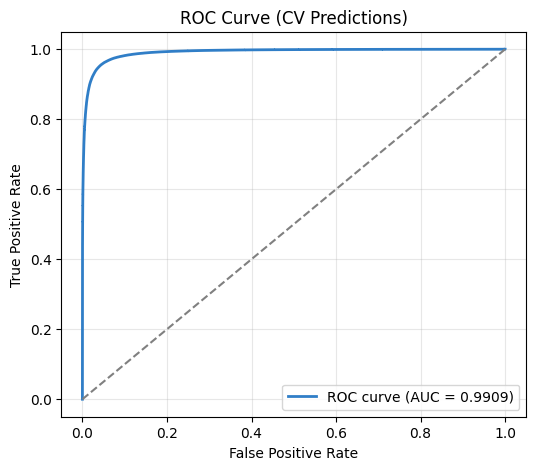

In [17]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_train, oof)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="#307ec7", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0,1],[0,1], color="gray", lw=1.5, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (CV Predictions)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

/tmp/ipykernel_15019/2060757036.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_feats, x="mean_tfidf", y="ngram", palette="Blues_r")


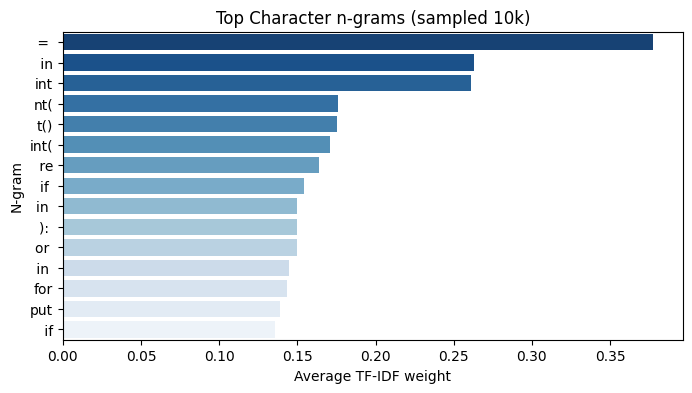

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

sample = train.sample(10000, random_state=42)
vec = TfidfVectorizer(analyzer="char", ngram_range=(3,5), max_features=20)
X_sample = vec.fit_transform(sample["code_nocom"])
tfidf_means = np.asarray(X_sample.mean(axis=0)).ravel()
top_feats = pd.DataFrame({"ngram": vec.get_feature_names_out(), "mean_tfidf": tfidf_means})
top_feats = top_feats.sort_values("mean_tfidf", ascending=False).head(15)

plt.figure(figsize=(8,4))
sns.barplot(data=top_feats, x="mean_tfidf", y="ngram", palette="Blues_r")
plt.title("Top Character n-grams (sampled 10k)")
plt.xlabel("Average TF-IDF weight")
plt.ylabel("N-gram")
plt.show()

In [19]:
from pathlib import Path
ART_DIR = Path("/home/marwa/Downloads/assignment2/artifacts/plots")
ART_DIR.mkdir(parents=True, exist_ok=True)

for i, fig in enumerate(map(plt.figure, plt.get_fignums()), 1):
    fig.savefig(ART_DIR / f"plot_{i}.png", bbox_inches="tight")
print("Saved all plots to:", ART_DIR)


Saved all plots to: /home/marwa/Downloads/assignment2/artifacts/plots


In [25]:
# === Export predictions on public test set as a plain text file ===
import pandas as pd

# Load the CSV you generated earlier
sub = pd.read_csv("artifacts/submission.csv")

# Validate structure
assert list(sub.columns) == ["ID", "label"], "submission.csv must have columns: ID,label"
assert len(sub) == 1000, "Expected 1000 rows (public test size)."

# Write out as a space-separated .txt file
txt_path = "artifacts/submission.txt"
sub.to_csv(txt_path, sep=" ", index=False, header=True)

print(f" Saved predictions to: {txt_path}")
print(sub.head(5))  # preview

 Saved predictions to: artifacts/submission.txt
     ID  label
0  2005      1
1  2384      0
2  3526      0
3  3926      0
4  7222      1


In [ ]:
# Save the environment's package list to requirements.txt
import subprocess

with open("requirements.txt", "w") as f:
    subprocess.run(["pip", "freeze"], stdout=f)

print("requirements.txt created in current directory")


requirements.txt created in current directory
